In [1]:
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import MonthEnd
import warnings
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import yfinance as yf
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold


# Turn off warnings
warnings.filterwarnings("ignore")

### Get NIFTY 50 historical data

In [2]:
# Define ticker and date rangticker = "BSE-500.BO"
start_date = "1980-01-01"
end_date = datetime.today().strftime('%Y-%m-%d')

ticker = '^NSEI'
# Download data
data = yf.download(ticker, start=start_date, end=end_date, interval="1d")

# Keep only the closing prices
data = data[['Close']]
data

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,^NSEI
Date,
2007-09-17,4494.649902
2007-09-18,4546.200195
2007-09-19,4732.350098
2007-09-20,4747.549805
2007-09-21,4837.549805
...,...
2025-02-25,22547.550781
2025-02-27,22545.050781


In [3]:
yf_market_data = data['Close'].resample('ME').last()
yf_market_data

Ticker,^NSEI
Date,
2007-09-30,5021.350098
2007-10-31,5900.649902
2007-11-30,5762.750000
2007-12-31,6138.600098
2008-01-31,5137.450195
...,...
2024-11-30,24131.099609
2024-12-31,23644.800781
2025-01-31,23508.400391


In [6]:
nifty_historical = pd.read_csv("./data/NIFTY 50_Historical_PRICE.csv")
nifty_historical['Date'] = pd.to_datetime(nifty_historical['Date'])
nifty_historical = nifty_historical.set_index('Date').resample('ME').ffill()
nifty_historical = nifty_historical[:'2007-10-01']
nifty_historical  = pd.DataFrame(nifty_historical['Close'])
nifty_historical = nifty_historical.rename(columns = {'Close': '^NSEI'})

In [7]:
market_data = pd.concat([nifty_historical, yf_market_data], axis=0)
market_data.iloc[5:]

,^NSEI
Date,
1990-12-31,330.860000
1991-01-31,314.360000
1991-02-28,379.940000
1991-03-31,366.450000
1991-04-30,389.010000
...,...
2024-11-30,24131.099609
2024-12-31,23644.800781
2025-01-31,23508.400391


In [8]:
initial_value = 100

market_data['Return'] = market_data['^NSEI'].pct_change()
market_data['Portfolio'] = initial_value * (1 + market_data['Return']).cumprod()
market_data['Portfolio'].iloc[0] = initial_value

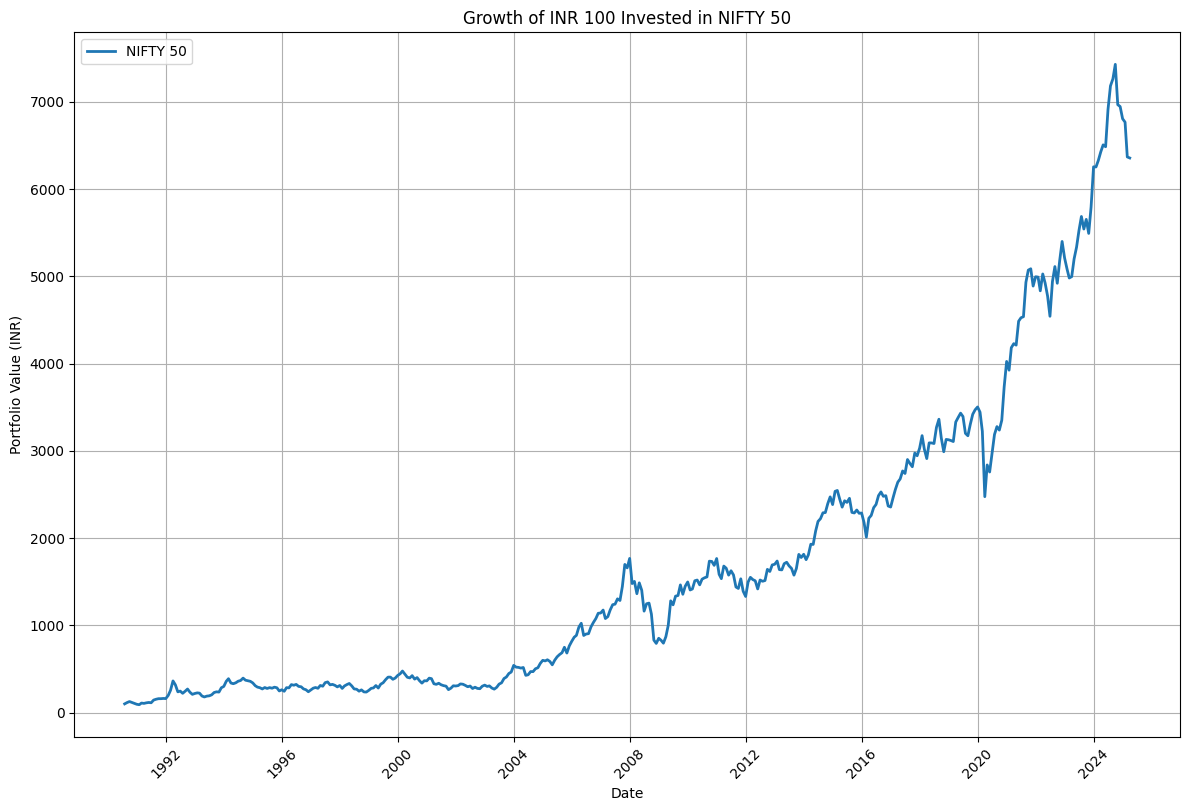

In [9]:
# Assuming 'portfolios' dictionary has the portfolios for each factor with 'Date' and 'Portfolio_Value'

# Step 1: Plotting the growth of portfolios for each factor
plt.figure(figsize=(12, 8))

# Plot the portfolio value over time
plt.plot(market_data.index, market_data['Portfolio'], label='NIFTY 50', linewidth = 2)

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Portfolio Value (INR)')
plt.title('Growth of INR 100 Invested in NIFTY 50')
plt.legend(loc='upper left')

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


In [10]:
market_data

,^NSEI,Return,Portfolio
Date,,,
1990-07-31,347.440000,NaN,100.000000
1990-08-31,400.060000,0.151451,115.145061
1990-09-30,439.720000,0.099135,126.559982
1990-10-31,403.660000,-0.082007,116.181211
1990-11-30,367.690000,-0.089110,105.828344
...,...,...,...
2024-11-30,24131.099609,-0.003068,6945.400532
2024-12-31,23644.800781,-0.020152,6805.434257
2025-01-31,23508.400391,-0.005769,6766.175567


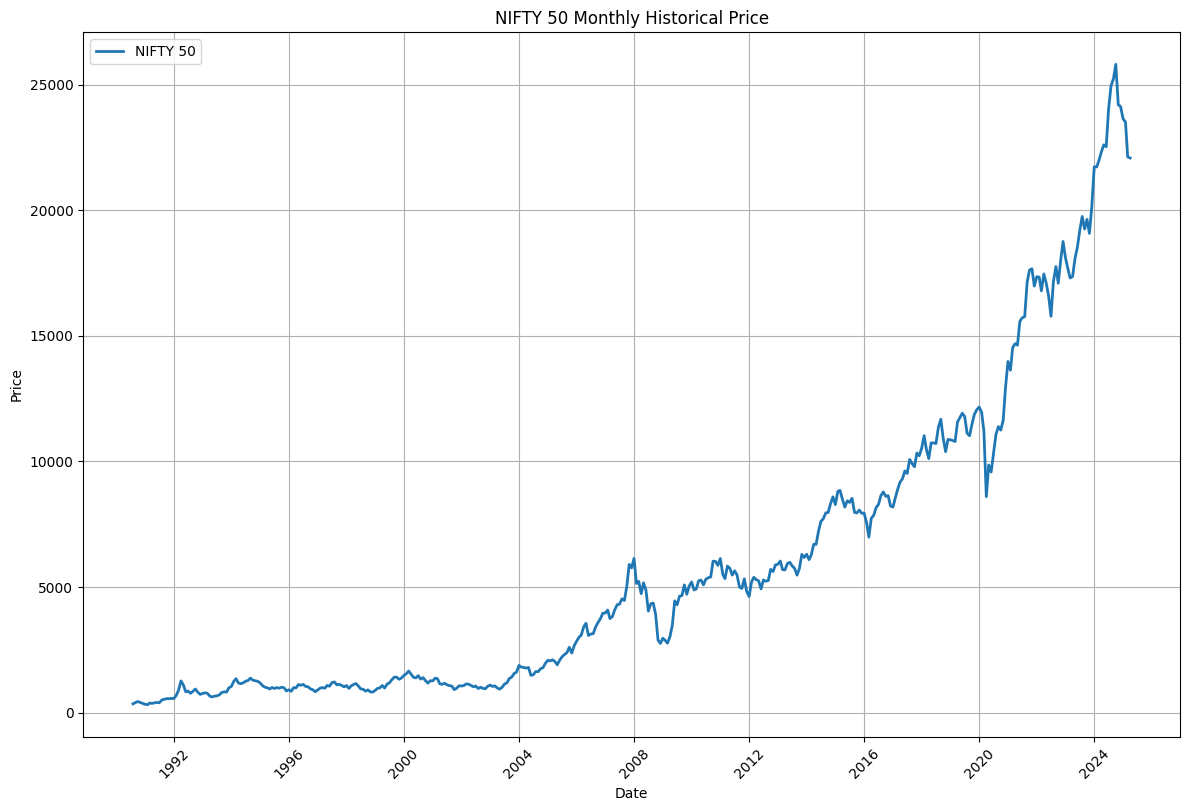

In [11]:
# Assuming 'portfolios' dictionary has the portfolios for each factor with 'Date' and 'Portfolio_Value'

# Step 1: Plotting the growth of portfolios for each factor
plt.figure(figsize=(12, 8))

# Plot the portfolio value over time
plt.plot(market_data.index, market_data['^NSEI'], label='NIFTY 50', linewidth = 2)

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('NIFTY 50 Monthly Historical Price')
plt.legend(loc='upper left')

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


### Return distribution

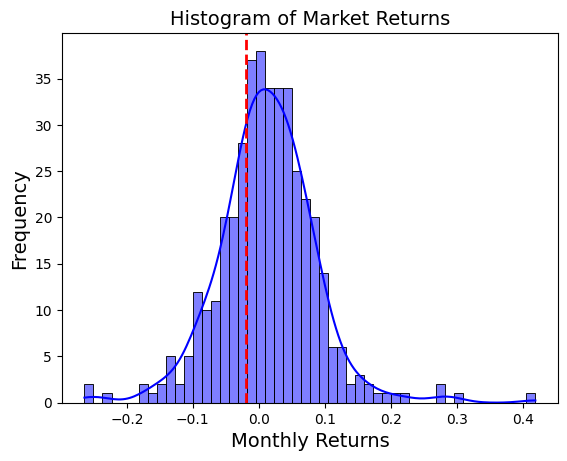

In [365]:
# Sample Data (Replace with your actual market_data DataFrame)
# market_data['Return'] should already contain daily returns
sns.histplot(market_data['Return'], bins=50, kde=True, color="blue")
plt.axvline(x=-0.02, color='red', linestyle='--', linewidth=2, label="Threshold (-0.02)")

# Set title and labels
plt.title("Histogram of Market Returns", fontsize=14)
plt.xlabel("Monthly Returns", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

# Show plot
plt.show()


### Creating Price Momentum Features

In [12]:
market_data['next_month_return'] = market_data['Return'].shift(1)

In [13]:
windows = [1, 3, 6, 9, 12]

market_data['momentum_1_1'] = market_data['^NSEI'] / market_data['^NSEI'].shift(1)
market_data['momentum_3_1'] = market_data['^NSEI'] / market_data['^NSEI'].shift(3)
market_data['momentum_6_1'] = market_data['^NSEI'] / market_data['^NSEI'].shift(6)
market_data['momentum_9_1'] = market_data['^NSEI'] / market_data['^NSEI'].shift(9)
market_data['momentum_12_1'] = market_data['^NSEI'] / market_data['^NSEI'].shift(12)


market_data.head(13)

,^NSEI,Return,Portfolio,next_month_return,momentum_1_1,momentum_3_1,momentum_6_1,momentum_9_1,momentum_12_1
Date,,,,,,,,,
1990-07-31,347.44,NaN,100.000000,NaN,NaN,NaN,NaN,NaN,NaN
1990-08-31,400.06,0.151451,115.145061,NaN,1.151451,NaN,NaN,NaN,NaN
1990-09-30,439.72,0.099135,126.559982,0.151451,1.099135,NaN,NaN,NaN,NaN
1990-10-31,403.66,-0.082007,116.181211,0.099135,0.917993,1.161812,NaN,NaN,NaN
1990-11-30,367.69,-0.089110,105.828344,-0.082007,0.910890,0.919087,NaN,NaN,NaN
1990-12-31,330.86,-0.100166,95.227953,-0.089110,0.899834,0.752433,NaN,NaN,NaN
1991-01-31,314.36,-0.049870,90.478932,-0.100166,0.950130,0.778774,0.904789,NaN,NaN
1991-02-28,379.94,0.208614,109.354133,-0.049870,1.208614,1.033316,0.949708,NaN,NaN
1991-03-31,366.45,-0.035506,105.471448,0.208614,0.964494,1.107568,0.833371,NaN,NaN


In [14]:
market_data.dropna(inplace=True)

### Training on 80% Data using Momentum Features

In [15]:
# Create the 'positive_returns' column
market_data['positive_returns'] = (market_data['next_month_return'] > -0.02).astype(int)

split_of_date_to_use = round(0.8*len(market_data))
# Features and target variable
X = market_data[['momentum_1_1', 'momentum_3_1', 'momentum_6_1', 'momentum_9_1', 'momentum_12_1']].iloc[:split_of_date_to_use]
y = market_data['positive_returns'].iloc[:split_of_date_to_use]

# Initialize the Random Forest Classifier
clf = RandomForestClassifier(n_estimators=10, random_state=42)

# Define k-fold cross-validation (-fold)
kfold = StratifiedKFold(n_splits=5, shuffle=False)

# Perform cross-validation
cv_scores = cross_val_score(clf, X, y, cv=kfold, scoring='accuracy')

# Train the model
clf.fit(X, y)

# Output results
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Accuracy: {np.mean(cv_scores):.4f}")
print(f"Standard Deviation: {np.std(cv_scores):.4f}")

Cross-Validation Scores: [0.67692308 0.67692308 0.78461538 0.75384615 0.8       ]
Mean Accuracy: 0.7385
Standard Deviation: 0.0524


### Making Predictions on Training Data

In [16]:
market_data['market_regime'] = clf.predict(market_data[['momentum_1_1', 'momentum_3_1', 'momentum_6_1', 'momentum_9_1', 'momentum_12_1']])

In [17]:
from sklearn.metrics import confusion_matrix

# Compute Confusion Matrix
cm = confusion_matrix(market_data["positive_returns"], market_data["market_regime"])

# Convert to DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

print(cm_df)


          Predicted 0  Predicted 1
Actual 0          107           11
Actual 1           16          272


### Making Predictions on Test Data

In [ ]:
test_data = market_data.iloc[split_of_date_to_use:]
test_data['market_regime'] = clf.predict(test_data[['momentum_1_1', 'momentum_3_1', 'momentum_6_1', 'momentum_9_1', 'momentum_12_1']])

In [20]:
# Compute Confusion Matrix
cm = confusion_matrix(test_data["positive_returns"], test_data["market_regime"])

# Convert to DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

print(cm_df)

          Predicted 0  Predicted 1
Actual 0           10           11
Actual 1           10           50


In [367]:
test_data.head()

,^NSEI,Return,Portfolio,next_month_return,momentum_1_1,momentum_3_1,momentum_6_1,momentum_9_1,momentum_12_1,positive_returns,market_regime
Date,,,,,,,,,,,
2018-07-31,11356.500000,0.059939,3268.621920,-0.002035,1.059939,1.057466,1.029816,1.098807,1.126961,1,1
2018-08-31,11680.500000,0.028530,3361.875432,0.059939,1.028530,1.087960,1.113187,1.142174,1.177719,1,1
2018-09-30,10930.450195,-0.064214,3145.996487,0.028530,0.935786,1.020174,1.080757,1.037960,1.116651,1,1
2018-10-31,10386.599609,-0.049756,2989.465695,-0.064214,0.950244,0.914595,0.967154,0.941865,1.004964,0,1
2018-11-30,10876.750000,0.047191,3130.540525,-0.049756,1.047191,0.931189,1.013096,1.036587,1.063580,0,0


## Training on Full Data

In [22]:
X_final = market_data[['momentum_1_1', 'momentum_3_1', 'momentum_6_1', 'momentum_9_1', 'momentum_12_1']].iloc[:-1]
y_final = market_data['positive_returns'].iloc[:-1]

# Initialize the Random Forest Classifier
clf = RandomForestClassifier(n_estimators=10, random_state=42)

# Define k-fold cross-validation (-fold)
kfold = StratifiedKFold(n_splits=5, shuffle=False)

# Perform cross-validation
cv_scores = cross_val_score(clf, X_final, y_final, cv=kfold, scoring='accuracy')

# Train the model
clf.fit(X_final, y_final)

# Output results
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Accuracy: {np.mean(cv_scores):.4f}")
print(f"Standard Deviation: {np.std(cv_scores):.4f}")

Cross-Validation Scores: [0.66666667 0.74074074 0.7654321  0.77777778 0.77777778]
Mean Accuracy: 0.7457
Standard Deviation: 0.0418


## Current Month Predicition

In [ ]:
last_month = np.array(market_data[['momentum_1_1', 'momentum_3_1', 'momentum_6_1', 'momentum_9_1', 'momentum_12_1']].iloc[-1]).reshape(1,-1)

final_prediction = clf.predict(last_month)
final_prediction[0]

### Adding consumption EPS as a feature

In [95]:
nifty_consumption_pe = pd.read_csv("./data/NIFTY INDIA CONSUMPTION_Historical.csv")
nifty_consumption_pe['Date'] = pd.to_datetime(nifty_consumption_pe['Date'])
nifty_consumption_pe = nifty_consumption_pe.set_index('Date').resample('ME').last()
nifty_consumption_pe.replace("-", pd.NA, inplace=True)  # Convert '-' to NaN
nifty_consumption_pe.fillna(method="ffill", inplace=True)  # Forward fill
nifty_consumption_pe

,IndexName,P/E,P/B,Div Yield %
Date,,,,
2011-07-31,NIFTY INDIA CONSUMPTION,24.09,4.38,1.42
2011-08-31,NIFTY INDIA CONSUMPTION,22.78,3.80,1.62
2011-09-30,NIFTY INDIA CONSUMPTION,22.32,3.68,1.64
2011-10-31,NIFTY INDIA CONSUMPTION,23.53,3.91,1.55
2011-11-30,NIFTY INDIA CONSUMPTION,21.90,3.64,1.64
...,...,...,...,...
2024-10-31,NIFTY INDIA CONSUMPTION,47.06,9.00,0.94
2024-11-30,NIFTY INDIA CONSUMPTION,46.63,8.97,0.95
2024-12-31,NIFTY INDIA CONSUMPTION,46.77,9.02,0.94


In [96]:
ticker_consumption = '^CNXCONSUM'
# Download data
data_consumption = yf.download(ticker_consumption, start=start_date, end=end_date, interval="1d")

# Keep only the closing prices
data_consumption = data_consumption[['Close']]
data_consumption = data_consumption.resample('ME').last()

[*********************100%***********************]  1 of 1 completed


In [ ]:
data_consumption['Close'].head()

Ticker,^CNXCONSUM
Date,
2011-07-31,1896.430054
2011-08-31,1807.989990
2011-09-30,1787.040039
2011-10-31,1898.369995
2011-11-30,1799.530029
...,...
2024-11-30,11447.400391
2024-12-31,11362.599609
2025-01-31,11115.599609


In [98]:
nifty_consumption_pe['P/E'] = nifty_consumption_pe['P/E'].replace('-', '0').astype(float)
consumption_data_merged = pd.merge(data_consumption['Close'], nifty_consumption_pe, left_index= True, right_index=True)

In [ ]:
consumption_data_merged['EPS'] = consumption_data_merged['^CNXCONSUM']/consumption_data_merged['P/E']
consumption_data_merged.loc[consumption_data_merged['EPS'] == np.float64('inf')]['EPS'] = 0

In [ ]:
training_data_with_eps = pd.merge(market_data,consumption_data_merged['EPS'], left_index=True, right_index=True, how='left')
training_data_with_eps.head()

,^NSEI,Return,Portfolio,next_month_return,momentum_1_1,momentum_3_1,momentum_6_1,momentum_9_1,momentum_12_1,positive_returns,market_regime,EPS
Date,,,,,,,,,,,,
1991-07-31,498.710000,0.272349,143.538453,-0.027829,1.272349,1.281998,1.586430,1.235470,1.435385,0,0,NaN
1991-08-31,531.970000,0.066692,153.111329,0.272349,1.066692,1.319435,1.400142,1.446789,1.329726,1,1,NaN
1991-09-30,553.790000,0.041017,159.391550,0.066692,1.041017,1.412874,1.511229,1.673790,1.259415,1,1,NaN
1991-10-31,554.400000,0.001102,159.567120,0.041017,1.001102,1.111668,1.425156,1.763583,1.373433,1,1,NaN
1991-11-30,563.170000,0.015819,162.091296,0.001102,1.015819,1.058650,1.396820,1.482260,1.531644,1,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-30,24131.099609,-0.003068,6945.400532,-0.062203,0.996932,0.956221,1.071032,1.097726,1.198575,0,0,245.494325
2024-12-31,23644.800781,-0.020152,6805.434257,-0.003068,0.979848,0.916080,0.984765,1.059027,1.088048,1,0,242.946325
2025-01-31,23508.400391,-0.005769,6766.175567,-0.020152,0.994231,0.971207,0.942177,1.039972,1.082055,0,0,244.298893


### Adding CAPE as a feature

In [ ]:
cape = pd.read_csv("./data/india_cape.csv")
cape['Date'] = pd.to_datetime(cape['Date'])
cape = cape.set_index('Date').resample('ME').last()
cape.head()

,BSE Sensex CAPE 10,BSE Sensex CAPE 7,BSE Sensex CAPE 5,NIFTY 500 CAPE 10,NIFTY 500 CAPE 7,NIFTY 500 CAPE 5
Date,,,,,,
1995-04-30,NaN,NaN,35.67,NaN,NaN,NaN
1995-05-31,NaN,NaN,33.25,NaN,NaN,NaN
1995-06-30,NaN,NaN,33.69,NaN,NaN,NaN
1995-07-31,NaN,NaN,32.58,NaN,NaN,NaN
1995-08-31,NaN,NaN,32.55,NaN,NaN,NaN
...,...,...,...,...,...,...
2024-09-30,37.21,36.11,34.30,45.99,43.16,39.21
2024-10-31,35.78,34.60,32.75,44.03,41.18,37.29
2024-11-30,34.74,33.47,31.58,42.14,39.28,35.48


In [ ]:
training_data_with_eps_and_cape = pd.merge(training_data_with_eps,cape['BSE Sensex CAPE 5'], left_index=True, right_index=True, how='left')
training_data_with_eps_and_cape.head()

,^NSEI,Return,Portfolio,next_month_return,momentum_1_1,momentum_3_1,momentum_6_1,momentum_9_1,momentum_12_1,positive_returns,market_regime,EPS,BSE Sensex CAPE 5
Date,,,,,,,,,,,,,
1991-07-31,498.710000,0.272349,143.538453,-0.027829,1.272349,1.281998,1.586430,1.235470,1.435385,0,0,NaN,NaN
1991-08-31,531.970000,0.066692,153.111329,0.272349,1.066692,1.319435,1.400142,1.446789,1.329726,1,1,NaN,NaN
1991-09-30,553.790000,0.041017,159.391550,0.066692,1.041017,1.412874,1.511229,1.673790,1.259415,1,1,NaN,NaN
1991-10-31,554.400000,0.001102,159.567120,0.041017,1.001102,1.111668,1.425156,1.763583,1.373433,1,1,NaN,NaN
1991-11-30,563.170000,0.015819,162.091296,0.001102,1.015819,1.058650,1.396820,1.482260,1.531644,1,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-30,24131.099609,-0.003068,6945.400532,-0.062203,0.996932,0.956221,1.071032,1.097726,1.198575,0,0,245.494325,31.58
2024-12-31,23644.800781,-0.020152,6805.434257,-0.003068,0.979848,0.916080,0.984765,1.059027,1.088048,1,0,242.946325,31.88
2025-01-31,23508.400391,-0.005769,6766.175567,-0.020152,0.994231,0.971207,0.942177,1.039972,1.082055,0,0,244.298893,30.24


### Addding Forex - Dollar to INR as a feature

In [144]:
fred_data = pd.read_csv("./data/USD_INR.csv")
fred_data['Date'] = pd.to_datetime(fred_data['Date'], format='%d-%m-%Y')
fred_data = fred_data.set_index('Date').resample('ME').last()
fred_data = fred_data[:'2003-11-30']
fred_data  = pd.DataFrame(fred_data['USD/INR'])
fred_data = fred_data.rename(columns = {'USD/INR': 'USDINR=X'})
fred_data.tail()

,USDINR=X
Date,
2003-07-31,46.15
2003-08-31,45.88
2003-09-30,45.78
2003-10-31,45.33
2003-11-30,45.82


In [145]:
ticker = 'USDINR=X'
# Download data
usd_inr = yf.download(ticker, start=start_date, end=end_date, interval="1d")

# Keep only the closing prices
usd_inr = usd_inr[['Close']]
usd_inr = usd_inr.resample('ME').last()

usd_inr = pd.concat([fred_data,usd_inr['Close']], axis=0)
usd_inr.head()

[*********************100%***********************]  1 of 1 completed

,USDINR=X
Date,
1973-01-31,8.00
1973-02-28,7.52
1973-03-31,7.55
1973-04-30,7.53
1973-05-31,7.39


In [146]:
training_data_with_eps_and_cape_and_usdinr = pd.merge(training_data_with_eps_and_cape, usd_inr['USDINR=X'], left_index=True, right_index=True, how='left')
training_data_with_eps_and_cape_and_usdinr.head()

,^NSEI,Return,Portfolio,next_month_return,momentum_1_1,momentum_3_1,momentum_6_1,momentum_9_1,momentum_12_1,positive_returns,market_regime,EPS,BSE Sensex CAPE 5,USDINR=X
Date,,,,,,,,,,,,,,
1991-07-31,498.71,0.272349,143.538453,-0.027829,1.272349,1.281998,1.586430,1.235470,1.435385,0,0,NaN,NaN,25.76
1991-08-31,531.97,0.066692,153.111329,0.272349,1.066692,1.319435,1.400142,1.446789,1.329726,1,1,NaN,NaN,25.82
1991-09-30,553.79,0.041017,159.391550,0.066692,1.041017,1.412874,1.511229,1.673790,1.259415,1,1,NaN,NaN,25.77
1991-10-31,554.40,0.001102,159.567120,0.041017,1.001102,1.111668,1.425156,1.763583,1.373433,1,1,NaN,NaN,25.84
1991-11-30,563.17,0.015819,162.091296,0.001102,1.015819,1.058650,1.396820,1.482260,1.531644,1,1,NaN,NaN,25.80


## Processing training data

Creating momentum features for USD INR

In [147]:
windows = [1, 3, 6, 9, 12]

for window in windows:
    column_name = 'momentum_' + str(window) + '_USDINR'
    training_data_with_eps_and_cape_and_usdinr[column_name] = training_data_with_eps_and_cape_and_usdinr['USDINR=X'] / training_data_with_eps_and_cape_and_usdinr['USDINR=X'].shift(window)

training_data_with_eps_and_cape_and_usdinr.head()

,^NSEI,Return,Portfolio,next_month_return,momentum_1_1,momentum_3_1,momentum_6_1,momentum_9_1,momentum_12_1,positive_returns,market_regime,EPS,BSE Sensex CAPE 5,USDINR=X,momentum_1_USDINR,momentum_3_USDINR,momentum_6_USDINR,momentum_9_USDINR,momentum_12_USDINR
Date,,,,,,,,,,,,,,,,,,,
1991-07-31,498.71,0.272349,143.538453,-0.027829,1.272349,1.281998,1.586430,1.235470,1.435385,0,0,NaN,NaN,25.76,NaN,NaN,NaN,NaN,NaN
1991-08-31,531.97,0.066692,153.111329,0.272349,1.066692,1.319435,1.400142,1.446789,1.329726,1,1,NaN,NaN,25.82,1.002329,NaN,NaN,NaN,NaN
1991-09-30,553.79,0.041017,159.391550,0.066692,1.041017,1.412874,1.511229,1.673790,1.259415,1,1,NaN,NaN,25.77,0.998064,NaN,NaN,NaN,NaN
1991-10-31,554.40,0.001102,159.567120,0.041017,1.001102,1.111668,1.425156,1.763583,1.373433,1,1,NaN,NaN,25.84,1.002716,1.003106,NaN,NaN,NaN
1991-11-30,563.17,0.015819,162.091296,0.001102,1.015819,1.058650,1.396820,1.482260,1.531644,1,1,NaN,NaN,25.80,0.998452,0.999225,NaN,NaN,NaN


momentum features for consumotion EPS

In [148]:
windows = [1, 3, 6, 9, 12]

for window in windows:
    column_name = 'momentum_' + str(window) + 'consumption_eps'
    training_data_with_eps_and_cape_and_usdinr[column_name] = training_data_with_eps_and_cape_and_usdinr['EPS'] / training_data_with_eps_and_cape_and_usdinr['EPS'].shift(window)

training_data_with_eps_and_cape_and_usdinr['2003-12-31':]

,^NSEI,Return,Portfolio,next_month_return,momentum_1_1,momentum_3_1,momentum_6_1,momentum_9_1,momentum_12_1,positive_returns,...,momentum_1_USDINR,momentum_3_USDINR,momentum_6_USDINR,momentum_9_USDINR,momentum_12_USDINR,momentum_1consumption_eps,momentum_3consumption_eps,momentum_6consumption_eps,momentum_9consumption_eps,momentum_12consumption_eps
Date,,,,,,,,,,,,,,,,,,,,,
2003-12-31,1879.750000,0.163752,541.028667,0.038145,1.163752,1.326477,1.657409,1.921642,1.719021,1,...,0.993671,0.994539,0.981250,0.957921,0.948542,NaN,NaN,NaN,NaN,NaN
2004-01-31,1809.750000,-0.037239,520.881303,0.163752,0.962761,1.163153,1.526121,1.937530,1.737054,1,...,0.988447,0.992808,0.975168,0.950053,0.940916,NaN,NaN,NaN,NaN,NaN
2004-02-29,1800.300000,-0.005222,518.161409,-0.037239,0.994778,1.114564,1.327117,1.788141,1.692966,0,...,1.004266,0.986381,0.985092,0.960187,0.948300,NaN,NaN,NaN,NaN,NaN
2004-03-31,1771.900000,-0.015775,509.987336,-0.005222,0.984225,0.942625,1.250370,1.562315,1.811388,1,...,0.958802,0.951768,0.946571,0.933922,0.911719,NaN,NaN,NaN,NaN,NaN
2004-04-30,1796.100000,0.013658,516.952567,-0.015775,1.013658,0.992458,1.154380,1.514610,1.922916,1,...,1.021923,0.984001,0.976925,0.959567,0.934853,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-30,24131.099609,-0.003068,6945.400532,-0.062203,0.996932,0.956221,1.071032,1.097726,1.198575,0,...,1.004549,1.006872,1.013811,1.018812,1.013696,1.006286,1.074649,1.128192,1.123058,1.161762
2024-12-31,23644.800781,-0.020152,6805.434257,-0.003068,0.979848,0.916080,0.984765,1.059027,1.088048,1,...,1.015567,1.024729,1.027989,1.028703,1.042339,0.989621,0.992101,1.101940,1.128811,1.146759
2025-01-31,23508.400391,-0.005769,6766.175567,-0.020152,0.994231,0.971207,0.942177,1.039972,1.082055,0,...,1.010030,1.030419,1.034727,1.038297,1.042562,1.005567,1.001385,1.112853,1.120849,1.139797


In [155]:
training_data_final = training_data_with_eps_and_cape_and_usdinr[['momentum_1_1',
       'momentum_3_1', 'momentum_6_1', 'momentum_9_1', 'momentum_12_1','BSE Sensex CAPE 5','momentum_1_USDINR', 'momentum_3_USDINR',
       'momentum_6_USDINR', 'momentum_9_USDINR', 'momentum_12_USDINR', 'positive_returns']]

training_columns = ['momentum_1_1',
       'momentum_3_1', 'momentum_6_1', 'momentum_9_1', 'momentum_12_1','BSE Sensex CAPE 5','momentum_1_USDINR', 'momentum_3_USDINR',
       'momentum_6_USDINR', 'momentum_9_USDINR', 'momentum_12_USDINR']

training_data_final.head()

,momentum_1_1,momentum_3_1,momentum_6_1,momentum_9_1,momentum_12_1,BSE Sensex CAPE 5,momentum_1_USDINR,momentum_3_USDINR,momentum_6_USDINR,momentum_9_USDINR,momentum_12_USDINR,positive_returns
Date,,,,,,,,,,,,
1991-07-31,1.272349,1.281998,1.586430,1.235470,1.435385,NaN,NaN,NaN,NaN,NaN,NaN,0
1991-08-31,1.066692,1.319435,1.400142,1.446789,1.329726,NaN,1.002329,NaN,NaN,NaN,NaN,1
1991-09-30,1.041017,1.412874,1.511229,1.673790,1.259415,NaN,0.998064,NaN,NaN,NaN,NaN,1
1991-10-31,1.001102,1.111668,1.425156,1.763583,1.373433,NaN,1.002716,1.003106,NaN,NaN,NaN,1
1991-11-30,1.015819,1.058650,1.396820,1.482260,1.531644,NaN,0.998452,0.999225,NaN,NaN,NaN,1


In [156]:
training_data_final = training_data_final.dropna()
training_data_final.head()

,momentum_1_1,momentum_3_1,momentum_6_1,momentum_9_1,momentum_12_1,BSE Sensex CAPE 5,momentum_1_USDINR,momentum_3_USDINR,momentum_6_USDINR,momentum_9_USDINR,momentum_12_USDINR,positive_returns
Date,,,,,,,,,,,,
1995-04-30,0.951113,0.879229,0.743237,0.736668,0.818556,35.67,1.000636,1.002311,1.002231,1.002470,1.002550,0
1995-05-31,1.059002,0.982951,0.800674,0.726333,0.840199,33.25,0.999364,1.000159,1.000955,1.001833,1.001833,0
1995-06-30,0.963736,0.970704,0.813086,0.744851,0.769353,33.69,0.999364,0.999364,1.001195,1.001355,1.001275,1
1995-07-31,1.034352,1.055658,0.928165,0.784604,0.777669,32.58,1.000637,0.999364,1.001673,1.001593,1.001833,0
1995-08-31,0.977360,0.974273,0.957662,0.780075,0.707646,32.55,1.013999,1.013999,1.014161,1.014968,1.015858,1


In [157]:
training_data_final.columns

Index(['momentum_1_1', 'momentum_3_1', 'momentum_6_1', 'momentum_9_1',
       'momentum_12_1', 'BSE Sensex CAPE 5', 'momentum_1_USDINR',
       'momentum_3_USDINR', 'momentum_6_USDINR', 'momentum_9_USDINR',
       'momentum_12_USDINR', 'positive_returns'],
      dtype='object')

## Training random forest model 

In [355]:
training_data_final

split_of_date_to_use = round(0.75*len(training_data_final))
# Features and target variable
X = training_data_final[training_columns].iloc[:split_of_date_to_use]
y = training_data_final['positive_returns'].iloc[:split_of_date_to_use]

# Initialize the Random Forest Classifier
clf = RandomForestClassifier(n_estimators=10, random_state=42)

# Define k-fold cross-validation (-fold)
kfold = StratifiedKFold(n_splits=5, shuffle=False)

# Perform cross-validation
cv_scores = cross_val_score(clf, X, y, cv=kfold, scoring='accuracy')

# Train the model
clf.fit(X, y)

# Output results
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Accuracy: {np.mean(cv_scores):.4f}")
print(f"Standard Deviation: {np.std(cv_scores):.4f}")

Cross-Validation Scores: [0.68518519 0.55555556 0.64814815 0.66666667 0.81132075]
Mean Accuracy: 0.6734
Standard Deviation: 0.0821


### Prediction on test data

In [361]:
from sklearn.metrics import accuracy_score

test_data_final = training_data_final.iloc[split_of_date_to_use:]
test_data_final['market_regime'] = clf.predict(test_data_final[training_columns])

# Compute Confusion Matrix
cm = confusion_matrix(test_data_final["positive_returns"], test_data_final["market_regime"])

# Convert to DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

print(cm_df)

acc_score = accuracy_score(test_data_final["positive_returns"], test_data_final["market_regime"])
print(f"Accuracy: {acc_score*100:.2f}%")

          Predicted 0  Predicted 1
Actual 0           12           10
Actual 1            7           61
Accuracy: 81.11%


In [353]:
test_data_final

,momentum_1_1,momentum_3_1,momentum_6_1,momentum_9_1,momentum_12_1,BSE Sensex CAPE 5,momentum_1_USDINR,momentum_3_USDINR,momentum_6_USDINR,momentum_9_USDINR,momentum_12_USDINR,positive_returns,market_regime
Date,,,,,,,,,,,,,
2019-02-28,0.996450,0.992254,0.923976,1.005249,1.028558,23.25,1.000984,1.018164,0.996989,1.055762,1.096749,1,1
2019-03-31,1.072041,1.065127,1.058511,1.079865,1.143993,24.07,0.976261,0.993958,0.952707,1.010223,1.068738,1,1
2019-04-30,1.015398,1.084683,1.131087,1.034487,1.093935,24.67,1.004486,0.981606,0.947886,1.016405,1.048068,1,1
2019-05-31,1.014866,1.104730,1.096173,1.020744,1.110528,24.39,1.002409,0.983003,1.000858,0.980043,1.037817,1,1
2019-06-30,0.988765,1.018915,1.085275,1.078533,1.100291,24.93,0.990640,0.997482,0.991455,0.950308,1.007679,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-30,1.022783,1.074977,1.156043,1.187721,1.314312,34.30,0.997870,1.003182,1.003878,1.017185,1.006291,1,1
2024-10-31,0.937797,0.970110,1.070803,1.114134,1.268651,32.75,1.004452,1.004181,1.007645,1.011784,1.009515,1,1
2024-11-30,0.996932,0.956221,1.071032,1.097726,1.198575,31.58,1.004549,1.006872,1.013811,1.018812,1.013696,0,0


## PCA and Logistic Regression

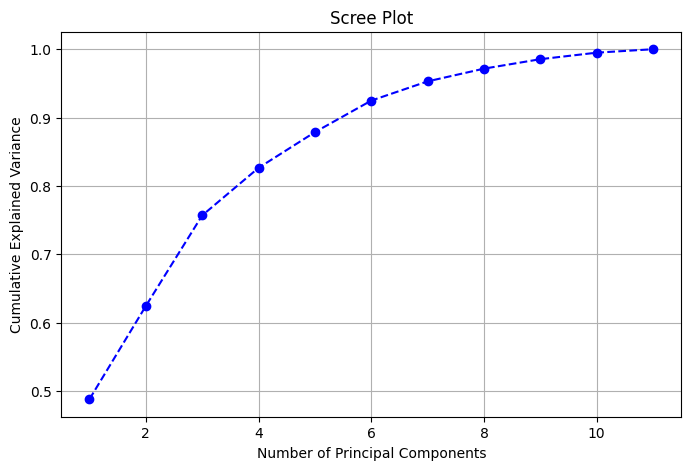

In [195]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(training_data_final[training_columns])

# Apply PCA
pca = PCA()
pca.fit(X_scaled)

# Plot the explained variance
plt.figure(figsize=(8,5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--', color='b')
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Scree Plot")
plt.grid()
plt.show()


In [196]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

y = training_data_final['positive_returns']

scores = []
for k in range(1, X.shape[1] + 1):
    pca = PCA(n_components=k)
    X_pca = pca.fit_transform(X_scaled)
    score = np.mean(cross_val_score(LogisticRegression(), X_pca, y, cv=5))
    scores.append(score)

optimal_k = np.argmax(scores) + 1
print(f"Optimal number of components based on CV: {optimal_k}")

Optimal number of components based on CV: 10


In [368]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.datasets import make_classification

X = training_data_final[training_columns].iloc[:split_of_date_to_use]
y = training_data_final['positive_returns'].iloc[:split_of_date_to_use]

# Step 2: Standardize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Apply PCA (retain enough variance)
pca = PCA(n_components=7)  # Choose components based on explained variance
X_pca = pca.fit_transform(X_scaled)

# Step 4: Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.8, random_state=42)

# Step 5: Train logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Step 6: Make predictions
y_pred = model.predict(X_test)

# Step 7: Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print results
print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", report)


X_scaled_full = scaler.fit_transform(X)
X_pca_full = pca.fit_transform(X_scaled_full)
model.fit(X_pca_full, y)

Accuracy: 0.75

Confusion Matrix:
 [[ 33  32]
 [ 22 129]]

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.51      0.55        65
           1       0.80      0.85      0.83       151

    accuracy                           0.75       216
   macro avg       0.70      0.68      0.69       216
weighted avg       0.74      0.75      0.74       216



LogisticRegression()

In [370]:
test_data_final_lr = training_data_final.iloc[split_of_date_to_use:]
X_test_scaled = scaler.fit_transform(test_data_final_lr[training_columns])
# Step 3: Apply PCA (retain enough variance)
X_pca_test = pca.fit_transform(X_test_scaled)

test_data_final_lr['market_regime'] = model.predict(X_pca_test)

# Compute Confusion Matrix
cm_lr = confusion_matrix(test_data_final_lr["positive_returns"], test_data_final_lr["market_regime"])

# Convert to DataFrame for better visualization
cm_df_lr = pd.DataFrame(cm_lr, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

print(cm_df_lr)

acc_score_lr = accuracy_score(test_data_final_lr["positive_returns"], test_data_final_lr["market_regime"])
print(f"Accuracy: {acc_score_lr*100:.2f}%")

          Predicted 0  Predicted 1
Actual 0            5           17
Actual 1           15           53
Accuracy: 64.44%


## XGBoost

In [371]:
import xgboost as xgb

# split_of_date_to_use = int(len(training_data_final)*0.8)
# Step 1: Generate Synthetic Data (Replace this with your dataset)
X = training_data_final[training_columns].iloc[:split_of_date_to_use]
y = training_data_final['positive_returns'].iloc[:split_of_date_to_use]

# Step 2: Standardize Data (Optional, but improves performance)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Split Data into Train and Test Sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.8, random_state=42)

# Step 3: Define XGBoost Model
model_xg = xgb.XGBClassifier(
    objective='binary:logistic',  # Binary classification
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=16,  # Number of trees
    learning_rate=0.1,  # Learning rate
    max_depth=3,  # Tree depth
    subsample=1,  # Fraction of samples used per tree
    colsample_bytree=0.8,  # Fraction of features used per tree
    random_state=42
)

# Step 4: Set Up K-Fold Cross-Validation
k = 5  # Number of folds
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Step 5: Perform Cross-Validation
cv_scores = cross_val_score(model_xg, X_scaled, y, cv=kf, scoring='accuracy')

# Step 6: Print Results
print(f"Cross-Validation Accuracies: {cv_scores}")
print(f"Mean Accuracy: {np.mean(cv_scores):.2f}")
print(f"Standard Deviation: {np.std(cv_scores):.2f}")

model_xg.fit(X, y)


Cross-Validation Accuracies: [0.77777778 0.77777778 0.85185185 0.75925926 0.73584906]
Mean Accuracy: 0.78
Standard Deviation: 0.04


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=16,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [372]:
test_data_xg = training_data_final.iloc[split_of_date_to_use:]
X_scaled_test_xg = scaler.fit_transform(test_data_xg[training_columns])
test_data_xg['market_regime'] = model_xg.predict(X_scaled_test_xg)
# Compute Confusion Matrix
cm_xg = confusion_matrix(test_data_xg["positive_returns"], test_data_xg["market_regime"])

# Convert to DataFrame for better visualization
cm_df_xg = pd.DataFrame(cm_xg, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

print(cm_df_xg)

acc_score_xg = accuracy_score(test_data_xg["positive_returns"], test_data_xg["market_regime"])
print(f"Accuracy: {acc_score_xg*100:.2f}%")

          Predicted 0  Predicted 1
Actual 0            9           13
Actual 1           12           56
Accuracy: 72.22%


In [354]:
test_data_xg

,momentum_1_1,momentum_3_1,momentum_6_1,momentum_9_1,momentum_12_1,BSE Sensex CAPE 5,momentum_1_USDINR,momentum_3_USDINR,momentum_6_USDINR,momentum_9_USDINR,momentum_12_USDINR,positive_returns,market_regime
Date,,,,,,,,,,,,,
2019-02-28,0.996450,0.992254,0.923976,1.005249,1.028558,23.25,1.000984,1.018164,0.996989,1.055762,1.096749,1,1
2019-03-31,1.072041,1.065127,1.058511,1.079865,1.143993,24.07,0.976261,0.993958,0.952707,1.010223,1.068738,1,0
2019-04-30,1.015398,1.084683,1.131087,1.034487,1.093935,24.67,1.004486,0.981606,0.947886,1.016405,1.048068,1,1
2019-05-31,1.014866,1.104730,1.096173,1.020744,1.110528,24.39,1.002409,0.983003,1.000858,0.980043,1.037817,1,1
2019-06-30,0.988765,1.018915,1.085275,1.078533,1.100291,24.93,0.990640,0.997482,0.991455,0.950308,1.007679,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-30,1.022783,1.074977,1.156043,1.187721,1.314312,34.30,0.997870,1.003182,1.003878,1.017185,1.006291,1,1
2024-10-31,0.937797,0.970110,1.070803,1.114134,1.268651,32.75,1.004452,1.004181,1.007645,1.011784,1.009515,1,1
2024-11-30,0.996932,0.956221,1.071032,1.097726,1.198575,31.58,1.004549,1.006872,1.013811,1.018812,1.013696,0,1
